### Imports

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image
import collections
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import multilabel_confusion_matrix
#import keras
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
#from keras.utils import to_categorical
#from keras.preprocessing import image

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout

import PIL
from copy import deepcopy

### Loading in data, train and test sets

In [3]:
train = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")
labels_data = pd.read_csv("data/labels.csv")

In [4]:
train

,image_id,labels
0,img256.jpg,l16 l18 l23 l25 l73
1,img98.jpg,l0 l24 l26 l39
2,img147.jpg,l14 l3
3,img254.jpg,l2 l25 l29
4,img160.jpg,l0 l32 l38 l40 l6
...,...,...
200,img105.jpg,l51
201,img198.jpg,l0 l10 l11 l65 l7
202,img82.jpg,l2
203,img124.jpg,l0 l1 l19 l22 l34 l6


### Turning labels column to multiple label columns
Kinda like onehotencoder

In [5]:
for label in labels_data.label_id:
  column_values = []
  for index, entry in train.iterrows():
    if label in entry.labels.split(" "):
      column_values.append(1)
    else:
      column_values.append(0)
  train[label] = column_values

In [6]:
train[:5]

,image_id,labels,l0,l1,l2,l3,l4,l5,l6,l7,...,l82,l83,l84,l85,l86,l87,l88,l89,l90,l91
0,img256.jpg,l16 l18 l23 l25 l73,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,img98.jpg,l0 l24 l26 l39,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,img147.jpg,l14 l3,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,img254.jpg,l2 l25 l29,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,img160.jpg,l0 l32 l38 l40 l6,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
print(train[:1].l16)
print(train[:1].l18)
print(train[:1].l23)
print(train[:1].l25)
print(train[:1].l73)

0    1
Name: l16, dtype: int64
0    1
Name: l18, dtype: int64
0    1
Name: l23, dtype: int64
0    1
Name: l25, dtype: int64
0    1
Name: l73, dtype: int64


### Reading in pictures

uint8
(450, 600, 3)


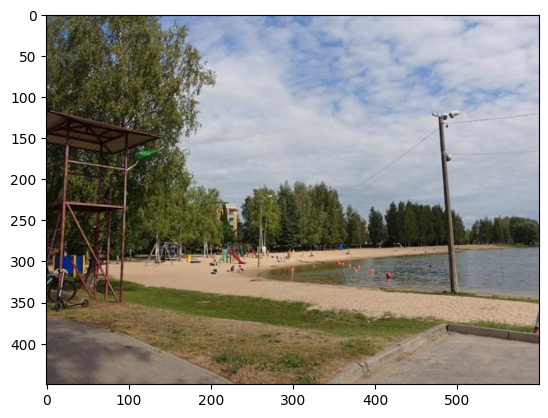

In [8]:
pic = image.imread("data/images/img120.jpg")
print(pic.dtype)
print(pic.shape)
plt.imshow(pic)
plt.show()

In [9]:
imageDir = "data/images/"
images = dict()
for imageName in os.listdir(imageDir):
  pic = image.imread(f"{imageDir}{imageName}")
  images[imageName] = pic

In [10]:
print(f"CSV files have {len(train) + len(test_data)} entries, but we have {len(images)} images.")

CSV files have 291 entries, but we have 294 images.


Going through train and test CSV and leaving only image entries that we have picture for.

In [11]:
train = train[train["image_id"].isin(images.keys())]
train = train.reset_index(drop=True)
test = test_data[test_data["image_id"].isin(images.keys())]
test = test_data.reset_index(drop=True)
print(len(train))
print(len(test_data))

201
86


In [12]:
train

,image_id,labels,l0,l1,l2,l3,l4,l5,l6,l7,...,l82,l83,l84,l85,l86,l87,l88,l89,l90,l91
0,img256.jpg,l16 l18 l23 l25 l73,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,img98.jpg,l0 l24 l26 l39,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,img147.jpg,l14 l3,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,img254.jpg,l2 l25 l29,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,img160.jpg,l0 l32 l38 l40 l6,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,img105.jpg,l51,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197,img198.jpg,l0 l10 l11 l65 l7,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
198,img82.jpg,l2,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199,img124.jpg,l0 l1 l19 l22 l34 l6,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Changing img278.jpg labels, because they are wrong.

In [13]:
#train.loc[train["image_id"] == "img278.jpg"]
#for label in ["l0", "l12", "l3", "l37", "l38", "l40", "l80"]:
#    train.at[143, label] = 0
# replacing
# for ...
#train.loc[train["image_id"] == "img278.jpg"]

# or just remove it
train.drop(train.loc[train["image_id"] == "img278.jpg"].index, inplace=True)
train.reset_index(drop=True, inplace=True)
train.loc[train["image_id"] == "img278.jpg"]


,image_id,labels,l0,l1,l2,l3,l4,l5,l6,l7,...,l82,l83,l84,l85,l86,l87,l88,l89,l90,l91


Adding imagedata to dataframe

In [14]:
train_images = []
test_images = []
for index, entry in train.iterrows():
  train_images.append(images[entry.image_id])
for index, entry in test.iterrows():
  test_images.append(images[entry.image_id])
train["image_data"] = train_images
test_data["image_data"] = test_images

In [15]:
train[:5]

,image_id,labels,l0,l1,l2,l3,l4,l5,l6,l7,...,l83,l84,l85,l86,l87,l88,l89,l90,l91,image_data
0,img256.jpg,l16 l18 l23 l25 l73,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[[[135, 159, 187], [135, 159, 187], [134, 158,..."
1,img98.jpg,l0 l24 l26 l39,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[[[176, 192, 205], [176, 192, 205], [177, 193,..."
2,img147.jpg,l14 l3,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[[[89, 73, 73], [98, 84, 83], [99, 88, 86], [1..."
3,img254.jpg,l2 l25 l29,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[[[159, 181, 202], [158, 180, 201], [158, 180,..."
4,img160.jpg,l0 l32 l38 l40 l6,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,"[[[149, 180, 162], [152, 185, 168], [153, 187,..."


In [16]:
train_X = train.image_data
train_y = train.drop(["image_id", "labels", "image_data"], axis = 1)
test_X = test_data.image_data

In [17]:
train_X[0]

array([[[135, 159, 187],
        [135, 159, 187],
        [134, 158, 186],
        ...,
        [216, 224, 237],
        [217, 224, 240],
        [215, 224, 239]],

       [[136, 160, 188],
        [135, 159, 187],
        [134, 158, 186],
        ...,
        [216, 224, 237],
        [217, 224, 240],
        [215, 224, 239]],

       [[136, 160, 188],
        [135, 159, 187],
        [134, 158, 186],
        ...,
        [216, 224, 237],
        [216, 223, 239],
        [215, 224, 239]],

       ...,

       [[ 57,  58,  63],
        [ 69,  70,  75],
        [ 71,  72,  77],
        ...,
        [115, 116, 120],
        [110, 111, 115],
        [110, 111, 115]],

       [[ 54,  54,  62],
        [ 60,  60,  68],
        [ 59,  59,  67],
        ...,
        [114, 115, 119],
        [121, 122, 126],
        [122, 123, 127]],

       [[ 61,  61,  71],
        [ 59,  59,  69],
        [ 62,  62,  70],
        ...,
        [113, 114, 118],
        [111, 112, 116],
        [113, 114, 118]]

In [18]:
train.labels

0        l16 l18 l23 l25 l73
1             l0 l24 l26 l39
2                     l14 l3
3                 l2 l25 l29
4          l0 l32 l38 l40 l6
               ...          
195                      l51
196        l0 l10 l11 l65 l7
197                       l2
198     l0 l1 l19 l22 l34 l6
199    l1 l15 l18 l2 l21 l71
Name: labels, Length: 200, dtype: object

In [52]:
train_y

,l0,l1,l2,l3,l4,l5,l6,l7,l8,l9,...,l82,l83,l84,l85,l86,l87,l88,l89,l90,l91
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
547,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
548,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
549,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<BarContainer object of 92 artists>

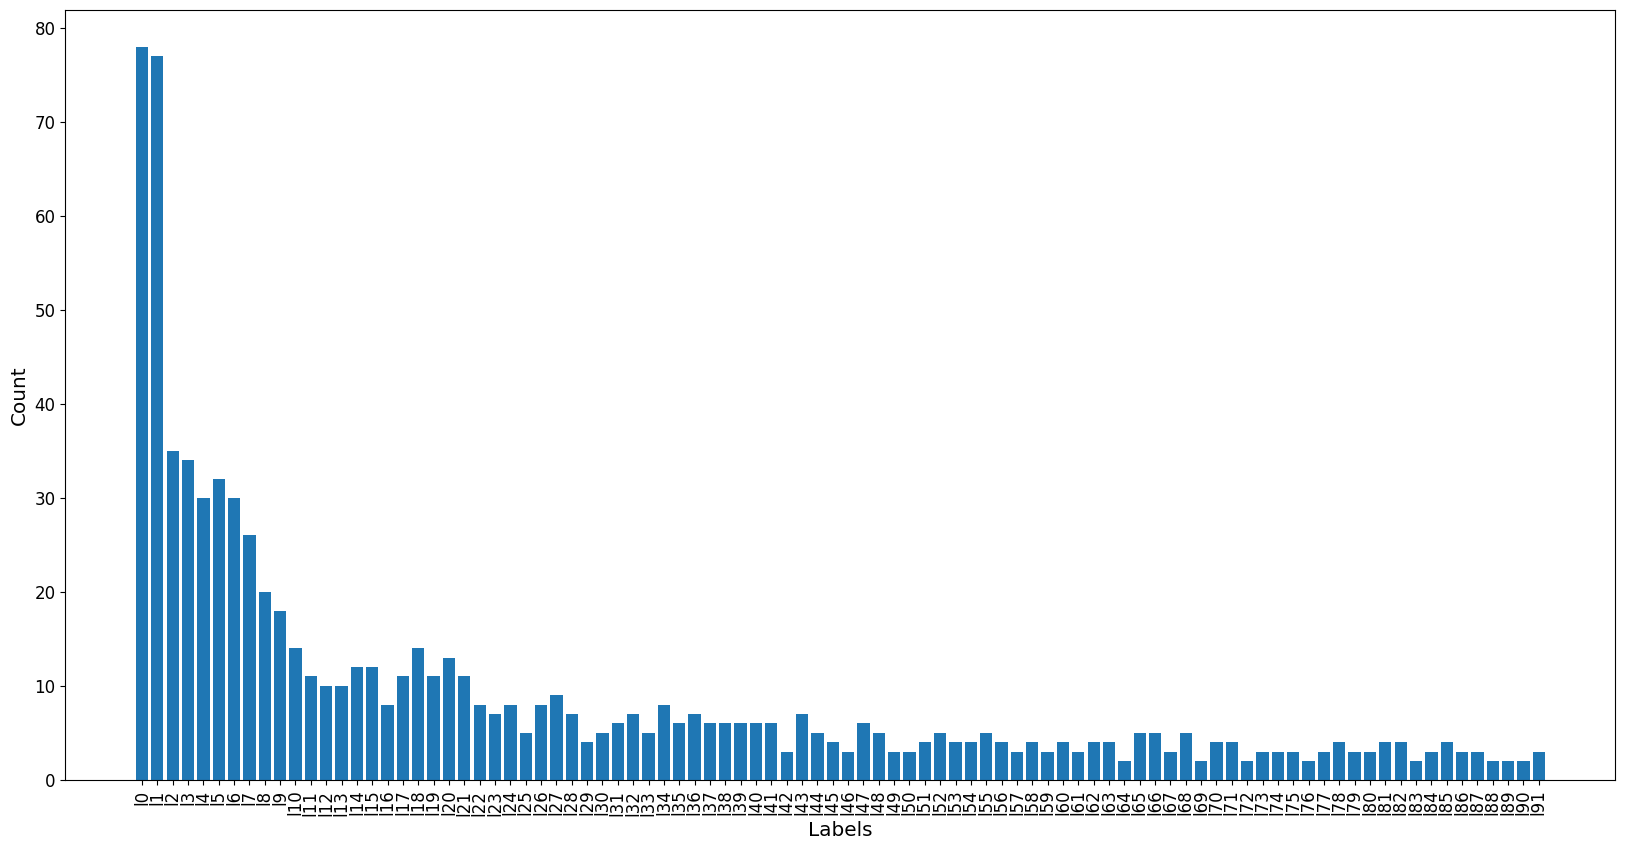

In [20]:
label = []
counts = []
for col in train_y:
    count = train_y[col].value_counts()
    label.append(col)
    counts.append(count[1])
count = train_y["l4"].value_counts()

plt.figure(figsize=(20, 10))
plt.xticks(rotation=90, fontsize="large")
plt.yticks(fontsize="large")
plt.xlabel("Labels", fontsize="x-large")
plt.ylabel("Count", fontsize="x-large")
plt.bar(label, counts)

In [50]:
train.to_pickle("./data/processed/train_cleaned.pkl")
test_data.to_pickle("./data/processed/test_cleaned.pkl")

Combining labels #TODO

In [21]:
combined = {
    "l0": "l0 l8", #people <- person
    "l1": "l1 l27", #trees <- tree
    "l3": "l3 l5", #building <- buildings
    "l4": "l4 l17", #snow <- winter
    
}

Remove labels that are not frequent.

In [22]:
train_less_labels = train.copy()

Removing onehot-columns

In [23]:
min_count = 5
for i in range(92):
    label = "l"+str(i)
    count = train_less_labels[label].sum()
    #print(count)
    if count < min_count:
        train_less_labels.drop(label, inplace=True, axis=1)

Fixing labels colummn values

In [24]:
remaining = ['l0', 'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'l7', 'l8', 'l9', 'l10', 'l11', 'l12', 'l13', 'l14', 'l15', 'l17', 'l18', 'l19', 'l20', 'l21']
len(remaining)

for i in range(len(train_less_labels)):
    new_values = " ".join([x for x in train_less_labels.iloc[i].labels.split(" ") if x in remaining])
    
    if i == 143:
        print(train_less_labels.iloc[i].labels)
        print(new_values)
    train_less_labels.iloc[i, 1] = new_values
    #train_fastai.loc[i, ["labels"]] = "a"

l13 l2 l23 l51
l13 l2


Removing rows where "labels" is empty

In [25]:
to_drop = []
for i, label in enumerate(train_less_labels.labels):
    if label == "":
        to_drop.append(i)
print(to_drop)
# img217
train_less_labels.drop(train_less_labels.index[to_drop], inplace=True)

[15, 19, 26, 27, 31, 57, 89, 97, 102, 106, 127, 136, 144, 175, 177, 193, 194, 195]


In [26]:
train_less_labels.reset_index(drop=True, inplace=True)
train_less_labels.head(20)

,image_id,labels,l0,l1,l2,l3,l4,l5,l6,l7,...,l43,l44,l47,l48,l52,l55,l65,l66,l68,image_data
0,img256.jpg,l18,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[[[135, 159, 187], [135, 159, 187], [134, 158,..."
1,img98.jpg,l0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[[[176, 192, 205], [176, 192, 205], [177, 193,..."
2,img147.jpg,l14 l3,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[[[89, 73, 73], [98, 84, 83], [99, 88, 86], [1..."
3,img254.jpg,l2,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[[[159, 181, 202], [158, 180, 201], [158, 180,..."
4,img160.jpg,l0 l6,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,"[[[149, 180, 162], [152, 185, 168], [153, 187,..."
5,img55.jpg,l3 l9,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[[[157, 161, 147], [150, 154, 140], [145, 145,..."
6,img202.jpg,l0 l1 l2 l20 l6,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,"[[[127, 133, 133], [155, 161, 161], [186, 191,..."
7,img214.jpg,l1 l20 l5 l6,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,"[[[246, 251, 254], [246, 251, 254], [246, 251,..."
8,img119.jpg,l11 l3,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[[[200, 199, 205], [200, 199, 205], [200, 199,..."
9,img201.jpg,l1 l10 l19 l6,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,"[[[162, 174, 188], [162, 174, 188], [162, 174,..."


In [27]:
train_X = train_less_labels.image_data
train_y = train_less_labels.drop(["image_id", "labels", "image_data"], axis = 1)
test_X = test_data.image_data

<BarContainer object of 50 artists>

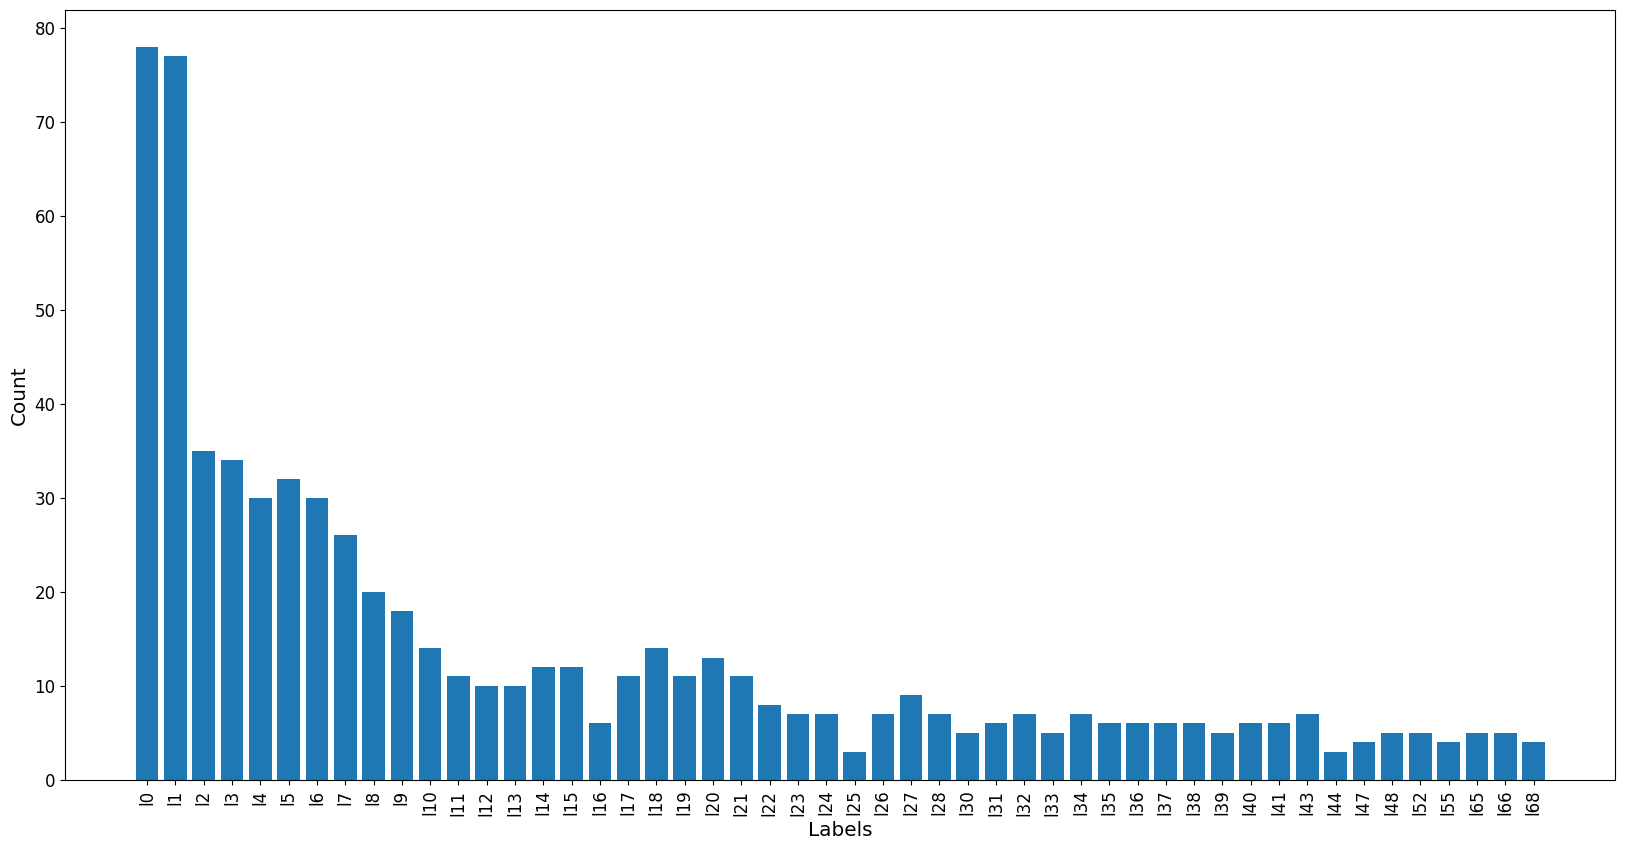

In [28]:
label = []
counts = []
for col in train_y:
    count = train_y[col].value_counts()
    label.append(col)
    counts.append(count[1])
count = train_y["l4"].value_counts()

plt.figure(figsize=(20, 10))
plt.xticks(rotation=90, fontsize="large")
plt.yticks(fontsize="large")
plt.xlabel("Labels", fontsize="x-large")
plt.ylabel("Count", fontsize="x-large")
plt.bar(label, counts)


In [54]:
train_less_labels.to_pickle(f'./data/processed/train_less_labels_{min_count}.pkl')

In [29]:
# remove some l0 and l1 images
#l0_indexes = []
#l1_indexes = []

#for index, row in train.iterrows():
#    if "l0" in row.labels and len(l0_indexes) < 40:
#        l0_indexes.append(index)
#    elif "l1" in row.labels and len(l1_indexes) < 40:
#        l1_indexes.append(index)

#print(len(l0_indexes))
#print(len(l1_indexes))

#to_remove = list(set(l0_indexes + l1_indexes))
#train_new = train.drop(train.index[to_remove])
#train_new = train_new.reset_index(drop=True)
#print(len(train_new))

What if we just oversample images with low label counts.

In [31]:
train_oversample = train.copy()

In [32]:
to_oversample = []
for index, row in train_oversample.iterrows():
    if not any(label in row.labels for label in ["l0", "l1", "l2", "l3", "l4", "l8"]):
        to_oversample.append(row)

print(len(to_oversample))
for row in to_oversample:
    for _ in range(20):
        train_oversample = pd.concat([train_oversample, row.to_frame().T])

6


In [33]:
#train_oversample.tail(3)

In [34]:
train_X = train_oversample.image_data
train_y = train_oversample.drop(["image_id", "labels", "image_data"], axis = 1)
test_X = test_data.image_data

<BarContainer object of 92 artists>

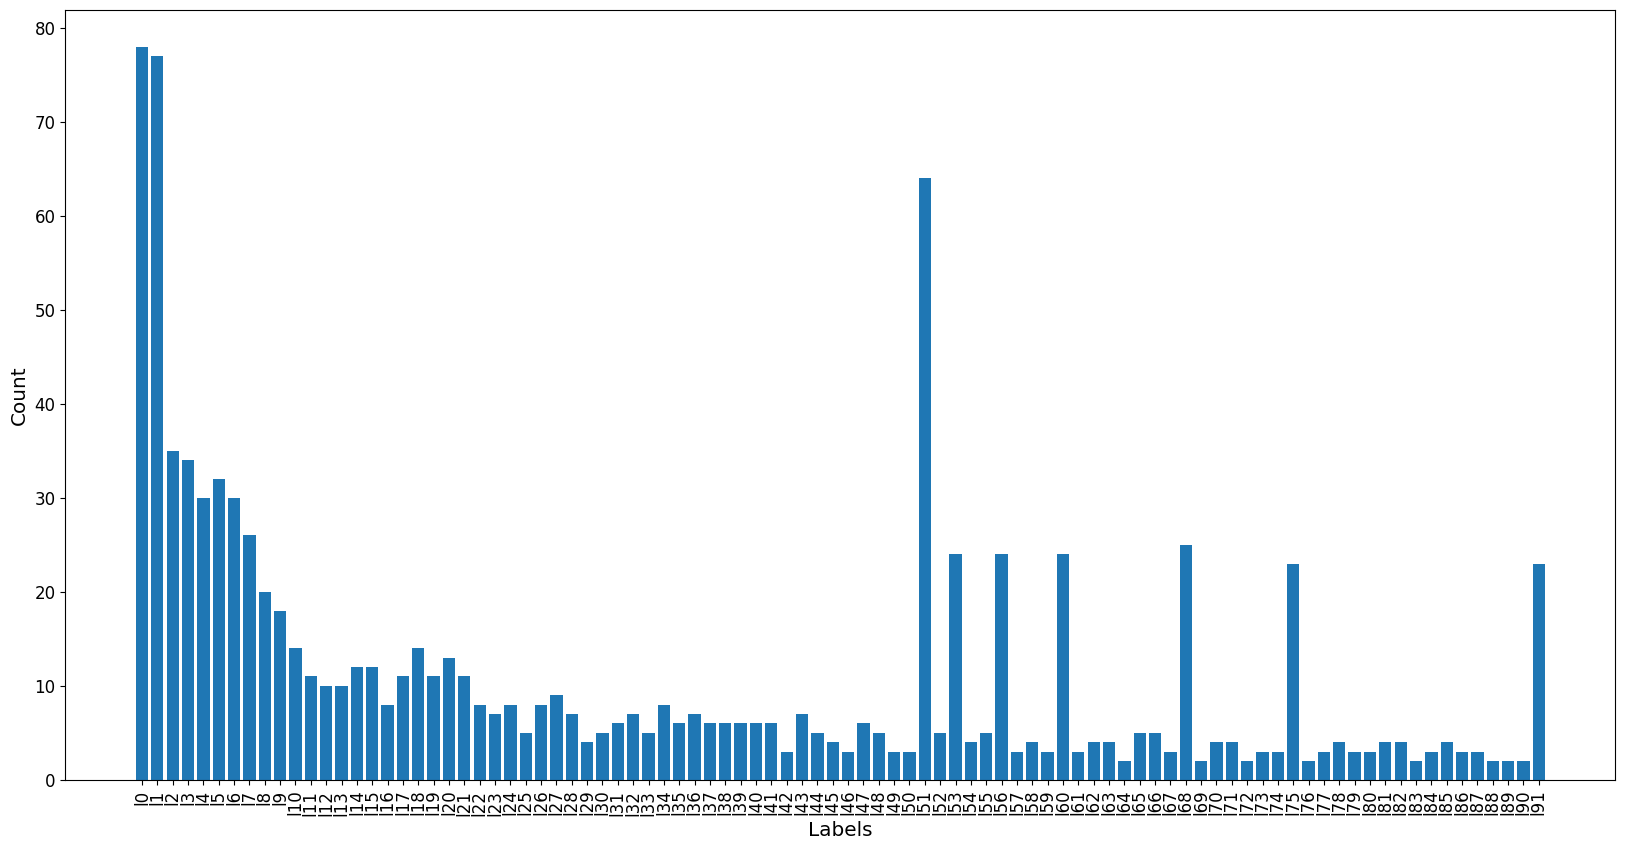

In [35]:
label = []
counts = []
for col in train_y:
    count = train_y[col].value_counts()
    label.append(col)
    counts.append(count[1])
count = train_y["l4"].value_counts()

plt.figure(figsize=(20, 10))
plt.xticks(rotation=90, fontsize="large")
plt.yticks(fontsize="large")
plt.xlabel("Labels", fontsize="x-large")
plt.ylabel("Count", fontsize="x-large")
plt.bar(label, counts)

Doesn't seem to be a good idea, there are not many pictures that don't have popular labels.

Oversampling by ratios

In [60]:
train_oversample_ratios = train.copy()

In [62]:
# trying https://www.kaggle.com/code/thedrcat/oversampling-for-multi-label-classification/notebook
label_counts = {}
count_sum = 0
for i in range(92):
    label = "l"+str(i)
    count = 0
    for labels in train_oversample_ratios["labels"]:
        if label in labels:
            count += 1
    label_counts[label] = count
    count_sum += count
label_counts["avg"] = int(count_sum/92)

def oversample_ratio(x):
    label_count = int(x)
    if label_count < label_counts["avg"]:
        return int(round(label_counts["avg"] / label_count))
    else: return 1

count_df = list(zip(label_counts.keys(), label_counts.values()))
count_df = np.array(sorted(count_df, key=lambda x:-x[1]))
count_df = pd.DataFrame(count_df, columns=["label", "full_count"])
count_df.set_index("label", inplace=True)
count_df["oversampling_ratio"] = count_df["full_count"].apply(oversample_ratio)
count_df.T

label,l1,l2,l3,l0,l4,l6,l5,l7,l8,l9,...,l87,l91,l64,l69,l72,l76,l83,l88,l89,l90
full_count,124,90,84,78,70,63,62,48,45,23,...,3,3,2,2,2,2,2,2,2,2
oversampling_ratio,1,1,1,1,1,1,1,1,1,1,...,4,4,6,6,6,6,6,6,6,6


In [63]:
def highest_ratio(row):
    ratio = 1
    labels = row[1].split(" ")
    for label in labels:
        r = count_df.oversampling_ratio.loc[label]
        if r > ratio: ratio = r
    return ratio

def lowest_ratio(row):
    ratio = 1000
    labels = row[1].split(" ")
    for label in labels:
        r = count_df.oversampling_ratio.loc[label]
        if r < ratio: ratio = r
    return ratio

rows = train_oversample_ratios.values.tolist()
print(len(rows))
oversampled_rows = [row for row in rows for _ in range(highest_ratio(row))]
print(len(oversampled_rows))

train_os_w_ratios = pd.DataFrame(oversampled_rows, columns=train_oversample_ratios.columns)
train_os_w_ratios.head(2)

200
551


,image_id,labels,l0,l1,l2,l3,l4,l5,l6,l7,...,l83,l84,l85,l86,l87,l88,l89,l90,l91,image_data
0,img256.jpg,l16 l18 l23 l25 l73,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[[[135, 159, 187], [135, 159, 187], [134, 158,..."
1,img256.jpg,l16 l18 l23 l25 l73,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[[[135, 159, 187], [135, 159, 187], [134, 158,..."


In [64]:
train_X = train_os_w_ratios.image_data
train_y = train_os_w_ratios.drop(["image_id", "labels", "image_data"], axis = 1)
test_X = test_data.image_data

<BarContainer object of 92 artists>

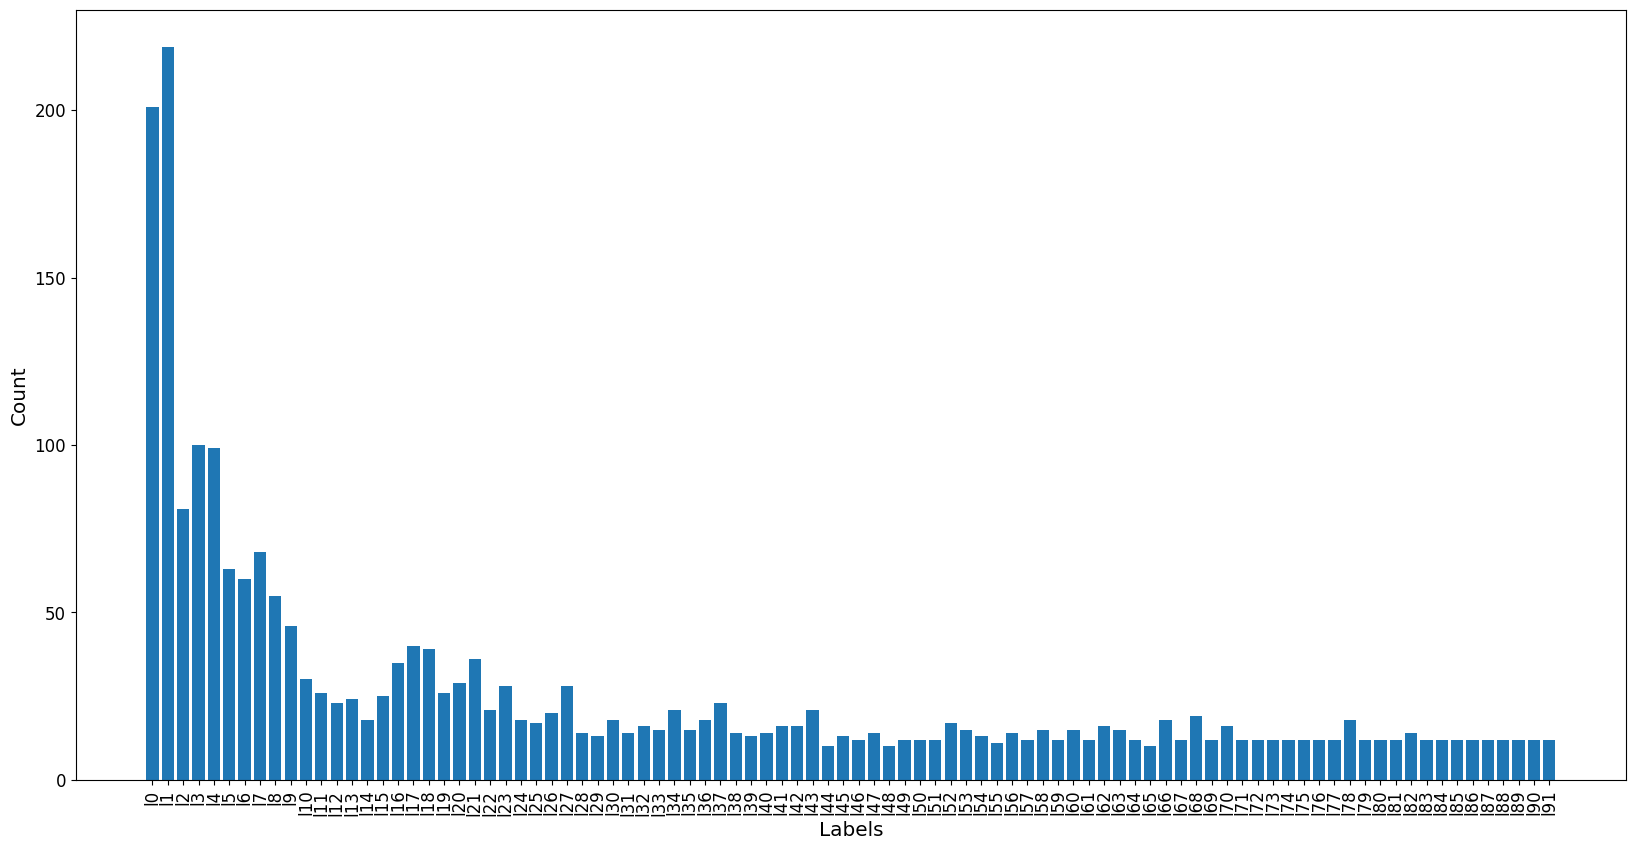

In [65]:
label = []
counts = []
for col in train_y:
    count = train_y[col].value_counts()
    label.append(col)
    counts.append(count[1])
count = train_y["l4"].value_counts()

plt.figure(figsize=(20, 10))
plt.xticks(rotation=90, fontsize="large")
plt.yticks(fontsize="large")
plt.xlabel("Labels", fontsize="x-large")
plt.ylabel("Count", fontsize="x-large")
plt.bar(label, counts)

In [61]:
train_os_w_ratios.to_pickle("./data/processed/train_oversample_w_ratios.pkl")

Just checking

img198 l0 l10 l11 l65 l7

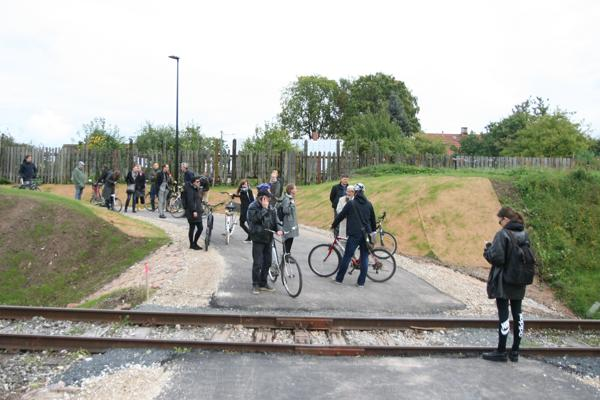

In [40]:
img198labels = train_y.iloc[[129]]
img198labels.columns[img198labels.iloc[0]==1]

Index(['l0', 'l4', 'l17', 'l27', 'l58', 'l63', 'l79'], dtype='object')

<class 'numpy.ndarray'>


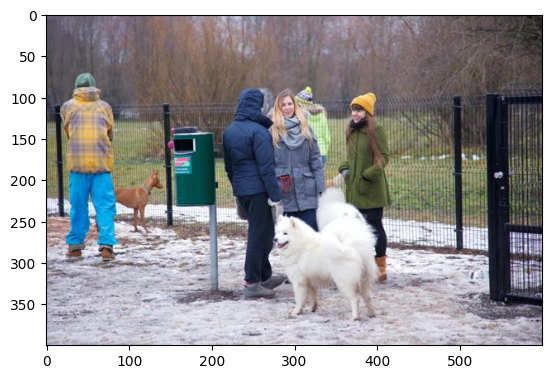

In [41]:
print(type(train_X.iloc[[178][0]]))
plt.imshow(train_X.iloc[[178][0]])
plt.show()

In [42]:
print(f"Loaded in {len(train_X), len(train_y)} train images and {len(test_X)} test images.")
print(f"Total: {len(train_X) + len(test_X)}")

Loaded in (551, 551) train images and 86 test images.
Total: 637


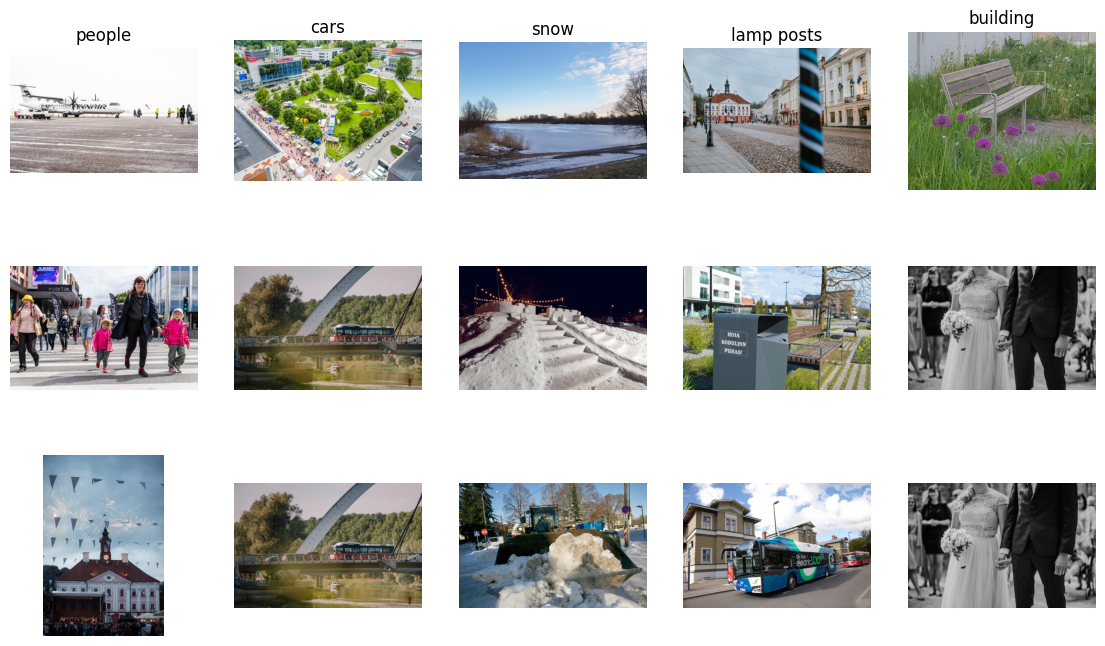

In [43]:
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots
# "Names" of classes:
class_names = ['l0','l9','l4','l15','l13']
readable_names = {"l0":"people", "l9":"cars", "l4":"snow", "l15":"lamp posts", "l13":"building"}
num_classes = len(class_names)

samples_per_class = 3 # Number of images from each class we want to see
for y, cls in enumerate(class_names):
    idxs = np.flatnonzero(train_y[cls])
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(train_X[idx], plt.get_cmap('gray'))
        plt.axis('off')
        if i == 0:
            plt.title(readable_names[cls])
plt.show()